Using device: cpu
Epoch 0, PDE Loss: 1.272024e+00
Epoch 1000, PDE Loss: 6.794471e-05
Epoch 2000, PDE Loss: 5.320883e-05
Epoch 3000, PDE Loss: 1.093813e-05
Epoch 4000, PDE Loss: 2.929966e-06
Epoch 5000, PDE Loss: 2.370377e-06
Epoch 6000, PDE Loss: 1.193736e-06
Epoch 7000, PDE Loss: 9.476527e-07
Epoch 8000, PDE Loss: 5.717960e-06
Epoch 9000, PDE Loss: 5.193469e-07
Epoch 10000, PDE Loss: 4.195131e-07
Epoch 11000, PDE Loss: 3.998185e-07
Epoch 12000, PDE Loss: 2.397350e-07
Epoch 13000, PDE Loss: 2.276112e-07
Epoch 14000, PDE Loss: 1.499793e-07
Epoch 15000, PDE Loss: 1.391336e-07
Epoch 16000, PDE Loss: 1.362112e-07
Epoch 17000, PDE Loss: 8.770964e-08
Epoch 18000, PDE Loss: 8.510951e-08
Epoch 19000, PDE Loss: 5.551478e-08


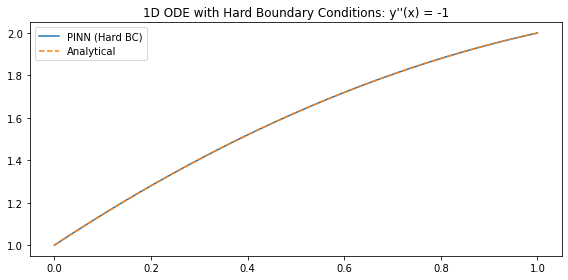

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 1D ODE with Hard Boundary Enforcement using PINNs

Problem:
    y''(x) = -1,  x in (0,1),
BCs:
    y(0) = 1, y(1) = 2
Analytical solution:
    y(x) = -0.5*x**2 + 1.5*x + 1

Hard BC via trial solution:
    y_theta(x) = A(x) + B(x) * N_theta(x)
    Choose A(x) = 1 + x       (satisfies y(0)=1, y(1)=2)
           B(x) = x*(1 - x)   (vanishes at x=0 and x=1)
Then y_theta(0)=1 and y_theta(1)=2 hold identically, so we only train on the PDE residual.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility (optional)
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class Net(nn.Module):
    """Small fully-connected network for N_theta(x)."""
    def __init__(self, hidden_units=20):
        super().__init__()
        self.layer1 = nn.Linear(1, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.act = nn.Tanh()

        # Xavier init for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        z = self.act(self.layer1(x))
        z = self.act(self.layer2(z))
        z = self.layer3(z)
        return z  # this is N_theta(x)

def A(x):
    """Anchor function satisfying the BCs exactly: A(0)=1, A(1)=2."""
    return 1.0 + x

def B(x):
    """Mask that vanishes at the boundary: B(0)=B(1)=0."""
    return x * (1.0 - x)

def y_trial(model, x):
    """Hard-BC trial solution y_theta(x) = A(x) + B(x)*N_theta(x)."""
    return A(x) + B(x) * model(x)

def residual(model, x):
    """
    Compute the ODE residual for y''(x) + 1 = 0 using the hard-BC trial solution.
    """
    x.requires_grad_(True)
    y = y_trial(model, x)

    # First derivative dy/dx
    dydx = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    # Second derivative d2y/dx2
    d2ydx2 = torch.autograd.grad(
        dydx, x,
        grad_outputs=torch.ones_like(dydx),
        create_graph=True
    )[0]

    res = d2ydx2 + 1.0  # should be 0
    return res

def main():
    model = Net(hidden_units=20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 20000

    # Interior collocation points in (0,1)
    N_interior = 80
    x_interior = torch.rand(N_interior, 1, device=device)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        r_int = residual(model, x_interior)
        loss_pde = torch.mean(r_int**2)

        # Only PDE residual (hard BCs already enforced)
        loss = loss_pde
        loss.backward()
        optimizer.step()

        # Optionally resample collocation points to reduce overfitting to a grid
        if (epoch + 1) % 100 == 0:
            x_interior = torch.rand(N_interior, 1, device=device)

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, PDE Loss: {loss.item():.6e}")

    # Evaluate
    model.eval()
    x_test = torch.linspace(0, 1, 200, device=device).unsqueeze(1)
    with torch.no_grad():
        y_pred = y_trial(model, x_test).cpu().numpy().flatten()
    x_np = x_test.cpu().numpy().flatten()

    # Analytical solution
    y_true = -0.5 * x_np**2 + 1.5 * x_np + 1.0

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(x_np, y_pred, label="PINN (Hard BC)")
    plt.plot(x_np, y_true, '--', label="Analytical")
    plt.title("1D ODE with Hard Boundary Conditions: y''(x) = -1")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
